In [20]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier



import warnings
warnings.filterwarnings("ignore")

np.random.seed(10)
pd.set_option('display.precision', 2)

In [21]:
df = pd.read_csv('C:/Users/Инна/Desktop/otus/Sample - Superstore.csv', encoding='Windows-1252')

Таргет: Столбец Profit.
Признаки: 
Тип задачи: Регрессия.

In [22]:
df[df['Profit']>=3000] #уберем из датасета строки с выбросами по признаку Profit

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
509,510,CA-2015-145352,3/16/2015,3/22/2015,Standard Class,CM-12385,Christopher Martinez,Consumer,United States,Atlanta,...,30318,South,OFF-BI-10003527,Office Supplies,Binders,Fellowes PB500 Electric Punch Plastic Comb Bin...,6354.95,5,0.0,3177.47
2623,2624,CA-2017-127180,10/22/2017,10/24/2017,First Class,TA-21385,Tom Ashbrook,Home Office,United States,New York City,...,10024,East,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,11199.97,4,0.2,3919.99
4098,4099,CA-2014-116904,9/23/2014,9/28/2014,Standard Class,SC-20095,Sanjit Chand,Consumer,United States,Minneapolis,...,55407,Central,OFF-BI-10001120,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,9449.95,5,0.0,4630.48
4190,4191,CA-2017-166709,11/17/2017,11/22/2017,Standard Class,HL-15040,Hunter Lopez,Consumer,United States,Newark,...,19711,East,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,10499.97,3,0.0,5039.99
6826,6827,CA-2016-118689,10/2/2016,10/9/2016,Standard Class,TC-20980,Tamara Chand,Corporate,United States,Lafayette,...,47905,Central,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,17499.95,5,0.0,8399.98
8153,8154,CA-2017-140151,3/23/2017,3/25/2017,First Class,RB-19360,Raymond Buch,Consumer,United States,Seattle,...,98115,West,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,13999.96,4,0.0,6719.98
9039,9040,CA-2016-117121,12/17/2016,12/21/2016,Standard Class,AB-10105,Adrian Barton,Consumer,United States,Detroit,...,48205,Central,OFF-BI-10000545,Office Supplies,Binders,GBC Ibimaster 500 Manual ProClick Binding System,9892.74,13,0.0,4946.37


In [23]:
#уберем из датасета строки где аномальная продажи (если они остались)
rows_to_drop2 = df[df['Sales'] >= 17000].index
df = df.drop(rows_to_drop2)

In [24]:
rows_to_drop = df[df['Profit'] >= 3000].index
df = df.drop(rows_to_drop)

In [25]:
df[df['Profit']>=3000]
df[df['Sales']>=17000]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit


In [26]:
print(df.isnull().sum().sum())

0


In [27]:
# Преобразование столбца 'Order Date' в формат datetime 
import pandas as pd
try:
    df['Order Date'] = pd.to_datetime(df['Order Date'])
except ValueError:
    print("Ошибка: не удалось преобразовать 'Order Date' в формат даты.  Проверьте формат данных в столбце.")
    exit()

df['Order Date'].head(3)

0   2016-11-08
1   2016-11-08
2   2016-06-12
Name: Order Date, dtype: datetime64[ns]

In [28]:
df['Month'] = df['Order Date'].dt.month_name()
df['Year'] = df['Order Date'].dt.year
df['Year'].head(3)

0    2016
1    2016
2    2016
Name: Year, dtype: int32

In [29]:
#удалим ненужные данные

# Список столбцов для удаления (добавьте все нужные)
columns_to_drop = [col for col in df.columns 
                  if 'ID' in col
                   or 'Date' in col
                   or 'id' in col
                   or 'Postal Code' in col
                   or 'Customer Name' in col
                   or 'Country' in col
                   or 'City' in col
                   or 'Product Name' in col
                   or 'State' in col]

# Удаляем выбранные столбцы
df_filtered = df.drop(columns=columns_to_drop)

print(f'''
Удалены столбцы:
{columns_to_drop}
''')
print(f'''
Оставшиеся столбцы:
{df_filtered.columns.tolist()}
''')


Удалены столбцы:
['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Customer ID', 'Customer Name', 'Country', 'City', 'State', 'Postal Code', 'Product ID', 'Product Name']


Оставшиеся столбцы:
['Ship Mode', 'Segment', 'Region', 'Category', 'Sub-Category', 'Sales', 'Quantity', 'Discount', 'Profit', 'Month', 'Year']



In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt  # Для визуализации

In [31]:
#преобразуем категориальные признаки (кроме Ship Mode т.к. там необходимо устнаовить класс доставки по возрастанию - от низкого до высокого)
df_filtered = pd.get_dummies(df_filtered, columns=['Category', 'Segment','Sub-Category', 'Region','Month', 'Year'])
df_filtered.head(3)#сделать это до разделения на трейн и тест!!!!!!!

,Ship Mode,Sales,Quantity,Discount,Profit,Category_Furniture,Category_Office Supplies,Category_Technology,Segment_Consumer,Segment_Corporate,...,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Year_2014,Year_2015,Year_2016,Year_2017
0,Second Class,261.96,2,0.0,41.91,True,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
1,Second Class,731.94,3,0.0,219.58,True,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
2,Second Class,14.62,2,0.0,6.87,False,True,False,False,True,...,True,False,False,False,False,False,False,False,True,False


In [32]:
#преобразуем категориальные признаки по столбцу Ship Mode
df_filtered['Ship Mode'].unique()

array(['Second Class', 'Standard Class', 'First Class', 'Same Day'],
      dtype=object)

In [33]:
ship_mode_mapping = {'Same Day': 1, 'First Class': int(2), 'Second Class': 3, 'Standard Class': 4}
df_filtered['Ship Mode'] = df_filtered['Ship Mode'].map(ship_mode_mapping)
df_filtered.head(3)

,Ship Mode,Sales,Quantity,Discount,Profit,Category_Furniture,Category_Office Supplies,Category_Technology,Segment_Consumer,Segment_Corporate,...,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Year_2014,Year_2015,Year_2016,Year_2017
0,3,261.96,2,0.0,41.91,True,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
1,3,731.94,3,0.0,219.58,True,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
2,3,14.62,2,0.0,6.87,False,True,False,False,True,...,True,False,False,False,False,False,False,False,True,False


In [34]:
X = df_filtered.drop('Profit', axis=1)
y = df_filtered['Profit']

In [35]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [263]:
# from scipy import stats

# # Уберем выбросы в Sales (в test и train выборках) т.к. они достаточно большие

# min_val = X_train['Sales'].min()
# min_val_test = X_test['Sales'].min()

# # 1. Определим константу для добавления
# if min_val <= 0 and min_val_test <= 0:
#     constant = abs(min_val) + 1e-6 # Добавляем небольшую константу
#     constant_test = abs(min_val_test) + 1e-6 
# else:
#     constant = 0  # Данные уже положительные
#     constant_test = 0

# # 2. Добавим константу ко всем значениям в столбце
# X_train['Sales'] = X_train['Sales'] + constant
# X_test['Sales'] = X_test['Sales'] + constant_test


# # 3. Выполним преобразование Бокса-Кокса
# transformed_data, lambda_value = stats.boxcox(X_train['Sales'])
# transformed_data_test, lambda_value = stats.boxcox(X_test['Sales'])


# # 4. Добавим преобразованные данные в DataFrame
# X_train['Sales'] = transformed_data
# X_test['Sales'] = transformed_data_test

# # 5. Выведем оптимальное значение lambda
# print(f"Optimal lambda value: {lambda_value}")
# print(f'среднее значение: {X_test['Sales'].mean()}')

Optimal lambda value: -0.04676055367777093
среднее значение: 3.7173487587438045


In [264]:
# # Уберем выбросы в таргете (в test и train выборках) т.к. они достаточно большие

# min_val2 = y_train.min()
# min_val2_test = y_test.min()


# # 3. Определим константу для добавления
# if min_val2 <= 0 or min_val2_test <= 0:
#     constant = abs(min_val2) + 1e-6
#     constant_test = abs(min_val2_test) + 1e-6 # Добавляем небольшую константу
# else:
#     constant = 0  # Данные уже положительные
#     constant_test = 0

# # 4. Добавим константу ко всем значениям в столбце
# y_train = y_train + constant
# y_test = y_test + constant


# # 5. Выполним преобразование Бокса-Кокса
# transformed_data2, lambda_value2 = stats.boxcox(y_train)
# transformed_data2_test, lambda_value2 = stats.boxcox(y_test)


# # 6. Добавим преобразованные данные в DataFrame
# y_train = transformed_data2
# y_test = transformed_data2_test

# # 7. Выведем оптимальное значение lambda
# print(f"Optimal lambda value: {lambda_value2}")

# print(f'среднее значение: {y_train.mean()}')


Optimal lambda value: 2.436000183493777
среднее значение: 5207914.683119753


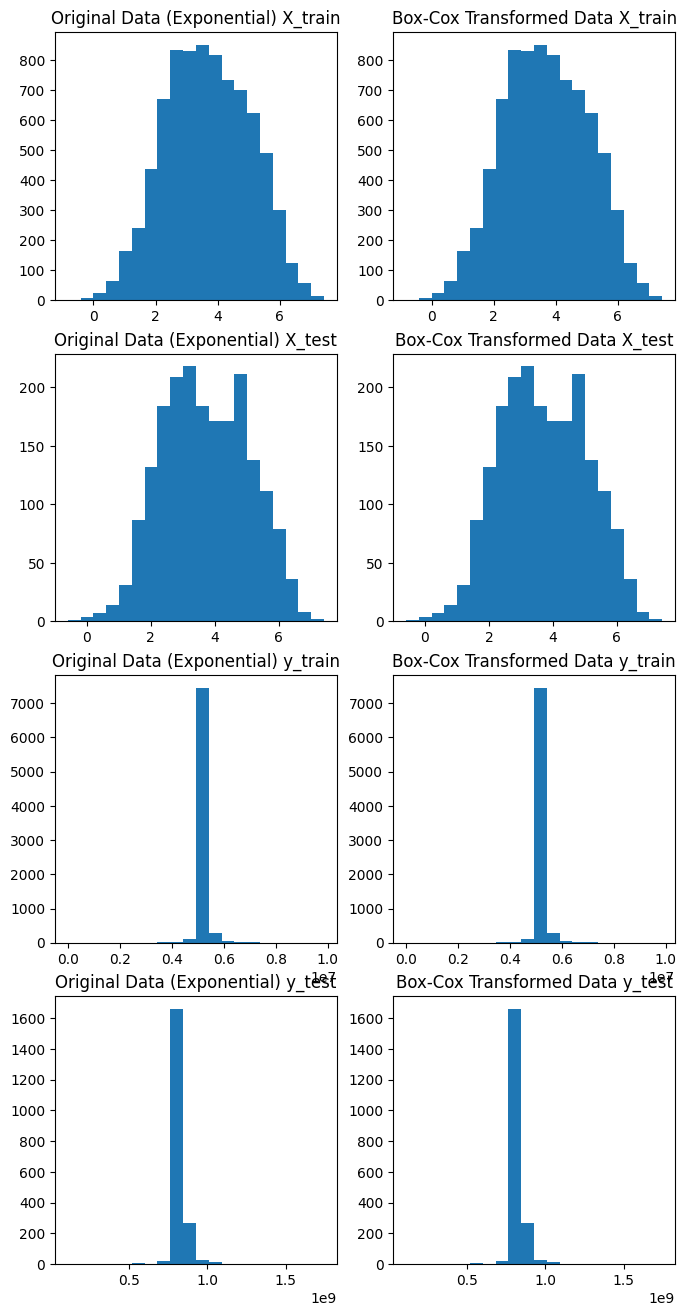

Shapiro-Wilk test: statistic=0.363, p-value=0.000


In [265]:
# from scipy import stats
# import matplotlib.pyplot as plt

# # 4. Визуализируем данные до и после преобразования
# fig, axes = plt.subplots(4, 2, figsize=(8, 16))


# # До преобразования
# axes[0, 0].hist(X_train['Sales'], bins=20)
# axes[0, 0].set_title("Original Data (Exponential) X_train")

# axes[1, 0].hist(X_test['Sales'], bins=20)
# axes[1, 0].set_title("Original Data (Exponential) X_test")

# axes[2, 0].hist(y_train, bins=20)
# axes[2, 0].set_title("Original Data (Exponential) y_train")

# axes[3, 0].hist(y_test, bins=20)
# axes[3, 0].set_title("Original Data (Exponential) y_test")


# # После преобразования 

# axes[0, 1].hist(transformed_data, bins=20)
# axes[0, 1].set_title("Box-Cox Transformed Data X_train")

# axes[1, 1].hist(transformed_data_test, bins=20)
# axes[1, 1].set_title("Box-Cox Transformed Data X_test")

# axes[2, 1].hist(transformed_data2, bins=20)
# axes[2, 1].set_title("Box-Cox Transformed Data y_train")

# axes[3, 1].hist(transformed_data2_test, bins=20)
# axes[3, 1].set_title("Box-Cox Transformed Data y_test")

# plt.show()

# # 5. Проверим нормальность преобразованных данных (например, с помощью теста Шапиро-Уилка)
# shapiro_test = stats.shapiro(transformed_data2)
# print(f"Shapiro-Wilk test: statistic={shapiro_test.statistic:.3f}, p-value={shapiro_test.pvalue:.3f}")

# # Интерпретация теста Шапиро-Уилка:
# # Если p-value > 0.05, то гипотеза о нормальности не отвергается.

In [36]:

# Получаем список названий столбцов
column_names = df_filtered.columns.tolist()

# Объединяем названия столбцов в строку, разделяя запятой и пробелом
column_names_string = ', '.join(column_names)

# Выводим строку
print(column_names_string)

Ship Mode, Sales, Quantity, Discount, Profit, Category_Furniture, Category_Office Supplies, Category_Technology, Segment_Consumer, Segment_Corporate, Segment_Home Office, Sub-Category_Accessories, Sub-Category_Appliances, Sub-Category_Art, Sub-Category_Binders, Sub-Category_Bookcases, Sub-Category_Chairs, Sub-Category_Copiers, Sub-Category_Envelopes, Sub-Category_Fasteners, Sub-Category_Furnishings, Sub-Category_Labels, Sub-Category_Machines, Sub-Category_Paper, Sub-Category_Phones, Sub-Category_Storage, Sub-Category_Supplies, Sub-Category_Tables, Region_Central, Region_East, Region_South, Region_West, Month_April, Month_August, Month_December, Month_February, Month_January, Month_July, Month_June, Month_March, Month_May, Month_November, Month_October, Month_September, Year_2014, Year_2015, Year_2016, Year_2017


In [ ]:
#остановилась на визуал-ии дерева решений, переделать рендом форест, у меня просто одно дерево решений!!!

IndexError: list index out of range

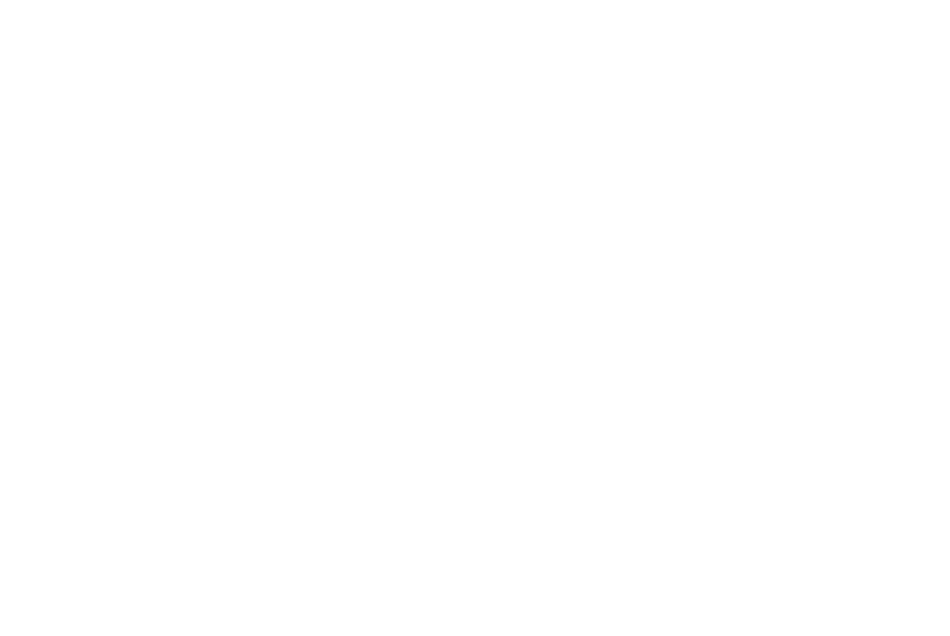

In [38]:
#пока не сделано(!!!)обучим модель на random forest
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
clf = DecisionTreeRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2, criterion='squared_error')#это не рэндом форест
clf.fit(X_train, y_train)
# absolute_error', 'squared_error
pred = clf.predict(X_test)
# print(classification_report(y_test, pred))

plt.figure(figsize=(12, 8))  # Настройте размер фигуры (ширина, высота)
tree.plot_tree(clf,
               filled=True,  # Заполнить узлы цветом
               feature_names=['Ship Mode	Sales',	'Quantity',	'Discount',	'Profit', 'Category_Furniture',	'Category_Office Supplies',	'Category_Technology',	'Segment_Consumer',	'Segment_Corporate','Segment_Home Office', 'Sub-Category_Accessories', 'Sub-Category_Appliances', 'Sub-Category_Art', 'Sub-Category_Binders', 'Sub-Category_Bookcases', 'Sub-Category_Chairs', 'Sub-Category_Copiers', 'Sub-Category_Envelopes', 'Sub-Category_Fasteners', 'Sub-Category_Furnishings', 'Sub-Category_Labels', 'Sub-Category_Machines', 'Sub-Category_Paper', 'Sub-Category_Phones', 'Sub-Category_Storage', 'Sub-Category_Supplies', 'Sub-Category_Tables', 'Region_Central', 'Region_East', 'Region_South', 'Region_West', 'Month_April', 'Month_August', 'Month_December', 'Month_February', 'Month_January', 'Month_June',	'Month_March',	'Month_May', 'Month_November',	'Month_October',	'Month_September',	'Year_2014',	'Year_2015',	'Year_2016',	'Year_2017'],  # Имена признаков
               rounded=True, # Округлить углы
               fontsize=10 #размер шрифта
               ) #  Обратите внимание на отступы!

plt.show() # Показать график

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Сделайте прогнозы на тестовой выборке
y_pred = clf.predict(X_test)

# Оцените модель
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

NameError: name 'clf' is not defined

In [39]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

#гиперпараметры
# Определите сетку параметров для поиска
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5]
}

# Создайте экземпляр GridSearchCV
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, scoring='r2')

# Запустите поиск
grid_search.fit(X_train, y_train)

# Выведите наилучшие параметры и наилучший результат
print("Best parameters:", grid_search.best_params_)
print("Best R-squared:", grid_search.best_score_)

# Используйте наилучшую модель для предсказаний
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")
print("R-squared on test set:", r2)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best R-squared: 0.5809292955931632
MSE: 18314.860676719858
R-squared on test set: 0.28093508485352137


In [157]:
# 1. Разделите данные
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# from sklearn.model_selection import KFold, GridSearchCV
# import catboost as cb
# from sklearn.datasets import make_regression


# # 1. Определим модель
# model = cb.CatBoostRegressor(random_state=42, learning_rate=0.01, depth=6, iterations=300, verbose=0)

# # 2. Определим сетку гиперпараметров для поиска
# param_grid = {
#     'iterations': [100, 200, 300],
#     'learning_rate': [0.01, 0.03, 0.05],
#     'depth': [6, 8, 12]
# }

# # 3. Определим стратегию кросс-валидации
# cv = KFold(n_splits=3, shuffle=True, random_state=42)

# # 4. Создадим объект GridSearchCV
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=cv, verbose=0)

# # 5. Запустим поиск по сетке
# grid_search.fit(X, y)

# # 6. Выведите результаты
# print("Лучшие гиперпараметры:", grid_search.best_params_)
# print("Лучшее значение R^2:", grid_search.best_score_)

# # 7. Получите лучшую модель
# best_model = grid_search.best_estimator_

Лучшие гиперпараметры: {'depth': 6, 'iterations': 300, 'learning_rate': 0.05}
Лучшее значение R^2: 0.839047893703296


In [44]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#CatBoostRegressor без преобразования данных
X = df_filtered.drop('Profit', axis=1)
y = df_filtered['Profit']

# 3. Определение категориальных признаков
# categorical_features_indices = np.where(X.dtypes != float)[0]  # Находим индексы не-числовых столбцов
categorical_features_indices = [X.columns.get_loc(col) for col in X.columns if X[col].dtype == 'object'] # Более явный способ


# 4. Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Создание Pool-объектов (необязательно, но рекомендуется)
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

# 6. Создание и обучение модели
model = CatBoostRegressor(iterations=300,
                            learning_rate=0.1,
                            depth=6,
                            loss_function='RMSE',
                            eval_metric='RMSE',
                            random_seed=42,
                            verbose=False) # verbose=False чтобы не выводить много текста

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=10) # early_stopping предотвратит переобучение

# 7. Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# 8. Оценка модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"r2_score: {r2:.4f}")


Mean Squared Error: 2956.8093
Mean Absolute Error: 17.9175
r2_score: 0.9067


In [45]:
df['Profit'].mean()

np.float64(25.172626517123973)

In [46]:
#сделаем проверку на примере конкретных данных из датасета
print(df.loc[[200]].T)

                                                             200
Row ID                                                       201
Order ID                                          CA-2017-105074
Order Date                                   2017-06-24 00:00:00
Ship Date                                              6/29/2017
Ship Mode                                         Standard Class
Customer ID                                             MB-17305
Customer Name                                    Maria Bertelson
Segment                                                 Consumer
Country                                            United States
City                                                       Akron
State                                                       Ohio
Postal Code                                                44312
Region                                                      East
Product ID                                       OFF-PA-10002666
Category                 

In [47]:
data = {'Ship Mode': [4],
        'Sales': [22],
        'Quantity': [3],
        'Discount': [0.2],
        'Category_Furniture': [False],
        'Category_Office Supplies': [True],
        'Category_Technology': [False],
        'Segment_Consumer': [True],
        'Segment_Corporate': [False],
        'Segment_Home Office': [False],
        'Sub-Category_Accessories': [False],  
        'Sub-Category_Appliances': [False],  
        'Sub-Category_Art': [False],            
        'Sub-Category_Binders': [False],      
        'Sub-Category_Bookcases': [False],   
        'Sub-Category_Chairs': [False],       
        'Sub-Category_Copiers': [False],      
        'Sub-Category_Envelopes': [False],      
        'Sub-Category_Fasteners': [False],      
        'Sub-Category_Furnishings': [True],  
        'Sub-Category_Labels': [False],       
        'Sub-Category_Machines': [False],     
        'Sub-Category_Paper': [False],        
        'Sub-Category_Phones': [False],          
        'Sub-Category_Storage': [False],     
        'Sub-Category_Supplies': [False],
        'Sub-Category_Tables': [False],
        'Region_Central': [False],
        'Region_East': [True],                 
        'Region_South': [False],               
        'Region_West': [False],                 
        'Month_April': [False],                  
        'Month_August': [False],                 
        'Month_December': [False],               
        'Month_February': [False],            
        'Month_January': [False],        
        'Month_July': [False],                  
        'Month_June': [True],                   
        'Month_March': [False],                 
        'Month_May': [False],               
        'Month_November': [False],              
        'Month_October': [False],               
        'Month_September': [False],        
        'Year_2014': [False],
        'Year_2015': [False],
        'Year_2016': [False],
        'Year_2017': [True]
       }

# Создаем DataFrame из словаря
data = pd.DataFrame(data)

In [48]:
y_predict = model.predict(data)
print(y_predict)

[2.43738973]
